<a href="https://colab.research.google.com/github/jeswitha2003/gtfs-lstm-mobility-forecasting/blob/main/GTFS_Mobility_Demand_Forecasting_Using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.listdir('/content/drive/MyDrive')


['Colab Notebooks',
 'CSV files',
 'scanner_20201219_153838.jpg',
 'Untitled document.gdoc',
 'Tirupati ',
 'Scanned Certificates.pdf',
 'adhaar and passport.pdf',
 '1. BE Contract Non-EU (Jeswitha Shivani Lakavath).pdf',
 'pythonpandas.csv',
 'Copy of Pandas.ipynb',
 'Colab_Notebooks.csv',
 'pandas',
 'bp',
 'projects',
 'artificial-intelligence-foundations-neural-networks-4381282-main',
 'Untitled folder',
 'serach from github.gsheet',
 'v1.0-mini',
 'hy',
 'datasets',
 'v1.0-mini (1).tgz',
 'nuscenes',
 'Saved from the Google app']

In [3]:
import pandas as pd
import zipfile

zip_path = "/content/drive/MyDrive/CSV files/GTFS.zip"
gtfs = zipfile.ZipFile(zip_path, "r")



In [4]:
import pandas as pd

stop_times = pd.read_csv(gtfs.open("stop_times.txt"))



/tmp/ipython-input-3267979643.py:3: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  stop_times = pd.read_csv(gtfs.open("stop_times.txt"))


In [5]:
stop_times = stop_times[stop_times['arrival_time'].str.match(r'^\d{1,2}:\d{2}:\d{2}$')]


In [6]:
stop_times['hour'] = stop_times['arrival_time'].str.split(':').str[0].astype(int)
stop_times['hour'] = stop_times['hour'] % 24


In [7]:
hourly_counts = (
    stop_times
    .groupby('hour')
    .size()
    .reset_index(name='total_trips')
    .sort_values('hour')
)


In [8]:
one_day = hourly_counts['total_trips'].values
print(one_day)
print(len(one_day))


[ 86549  44907  35708  42449  83091 167474 256609 294259 275750 294785
 298820 304274 317481 338698 359316 360326 350129 330752 304855 273672
 215527 158802 133388 113374]
24


In [9]:
import numpy as np

num_days = 90
series = np.tile(one_day, num_days)

print(series)
print("Length:", len(series))


[ 86549  44907  35708 ... 158802 133388 113374]
Length: 2160


In [10]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

scaler = MinMaxScaler()
scaled_series = scaler.fit_transform(series.reshape(-1, 1)).flatten()


In [11]:
seq_len = 24
X = []
y = []

for i in range(len(scaled_series) - seq_len):
    X.append(scaled_series[i : i + seq_len])
    y.append(scaled_series[i + seq_len])

X = np.array(X)
y = np.array(y)


In [12]:
X = X.reshape((X.shape[0], X.shape[1], 1))
print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (2136, 24, 1)
y shape: (2136,)


In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(seq_len, 1)),
    LSTM(32),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
history = model.fit(
    X, y,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)


Epoch 1/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - loss: 0.1826 - val_loss: 0.0519
Epoch 2/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0240 - val_loss: 0.0081
Epoch 3/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0066 - val_loss: 0.0074
Epoch 4/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0068 - val_loss: 0.0026
Epoch 5/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0025 - val_loss: 0.0021
Epoch 6/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 7/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0014 - val_loss: 0.0010
Epoch 8/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 9.9238e-04 - val_loss: 0.0011
Epoch 9/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0011 - val_loss: 6.5542e-04
Epoch 10/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 7.2345e-04 - val_loss: 7.3482e-04
Epoch 11/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 8.1536e-04 - val_loss: 0.0010
Epoch 12/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 2

In [15]:
last_sequence = scaled_series[-seq_len:].reshape(1, seq_len, 1)
pred_scaled = model.predict(last_sequence)
predicted_value = scaler.inverse_transform(pred_scaled.reshape(-1, 1))[0][0]

print("Predicted next hour mobility:", predicted_value)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
Predicted next hour mobility: 81482.586


67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


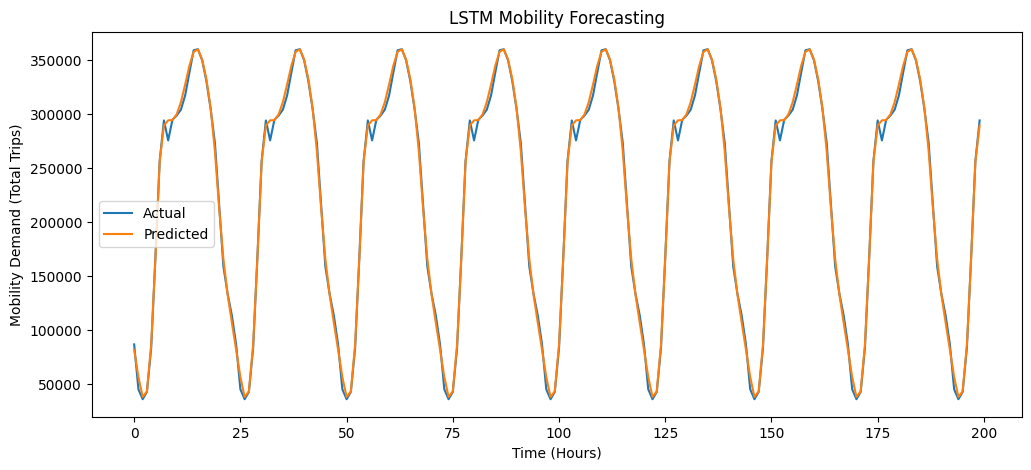

In [16]:
import matplotlib.pyplot as plt

y_pred = model.predict(X)
y_pred = scaler.inverse_transform(y_pred)

actual = scaler.inverse_transform(y.reshape(-1,1))

plt.figure(figsize=(12,5))
plt.plot(actual[:200], label='Actual')
plt.plot(y_pred[:200], label='Predicted')
plt.xlabel("Time (Hours)")
plt.ylabel("Mobility Demand (Total Trips)")
plt.title("LSTM Mobility Forecasting")
plt.legend()
plt.show()
